# Research Trotterization residuals

In [1]:
import itertools
from dataclasses import dataclass

import numpy as np
import qutip as qp
import matplotlib.pyplot as plt

from quanty.geometry import UniformChain
from quanty.hamiltonian import XX, XXZ
from quanty.model.homo import Homogeneous

In [2]:
import sys, pathlib

sys.path.append(str(pathlib.Path.cwd().parent))

In [3]:
%load_ext autoreload
%autoreload 2

from orrvciwe import TransferProblem, TransferTask, dephasing_operator

In [4]:
@dataclass(frozen=True)
class DephasedRho:
    t: float
    nt: int
    gammas: tuple[float, float]
    atol: float = 1e-13
    rtol: float = 1e-12

    def run(self):
        cat = (qp.fock(2, 1) + qp.fock(2, 0)) / np.sqrt(2)
        ket = qp.tensor(cat, cat)
        rho = ket.proj()

        c_ops = [
            np.sqrt(self.gammas[0]) * qp.tensor(qp.sigmaz(), qp.identity(2)) / 2,
            np.sqrt(self.gammas[1]) * qp.tensor(qp.identity(2), qp.sigmaz()) / 2,
        ]
        ham = 0.25 * (
            qp.tensor(qp.sigmax(), qp.sigmax())
            + qp.tensor(qp.sigmay(), qp.sigmay())
            - 2 * qp.tensor(qp.sigmaz(), qp.sigmaz())
        )
        options = {
            "atol": self.atol,
            "rtol": self.rtol,
        }
        rho_dephased = qp.mesolve(
            ham, rho, np.linspace(0, self.t, 2), c_ops=c_ops, options=options
        ).states[-1]
        # rho_dephased = qp.sesolve(ham, ket, np.linspace(0, t, 2), options=options).states[-1].proj()

        geometry = UniformChain()
        model = Homogeneous(geometry)  # All with all !
        ham_ = XXZ(model)
        rho_ = rho.full()
        tt = self.t / self.nt
        u = ham_.U(2, tt)
        ul = dephasing_operator(tt, self.gammas, ex=None)
        for it in range(self.nt):
            rho_ = u @ rho_ @ u.conjugate().transpose()
            rho_ = rho_ * ul
        rho_dephased_ = rho_

        return rho_dephased, rho_dephased_

    def residual(self):
        rho, rho_ = self.run()
        return np.max(np.abs(rho.full() - rho_))

In [5]:
%%time

t_end_set = (10,)
gammas_set = (
    (1, 0.5),
    (0.1, 0.05),
    (0.01, 0.005),
)
nt_span = np.logspace(0, 3, 4).astype(int)
residuals = {}
for t_end, nt, gammas in itertools.product(t_end_set, nt_span, gammas_set):
    key = (t_end, nt, gammas)
    residuals[key] = DephasedRho(t=t_end, nt=int(nt), gammas=gammas).residual()

CPU times: user 58.1 ms, sys: 4.46 ms, total: 62.6 ms
Wall time: 62.5 ms


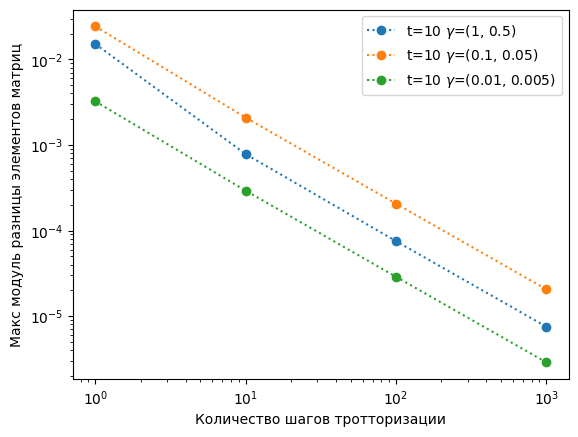

In [6]:
ax = plt.subplot(111)
for t_end, gammas in itertools.product(t_end_set, gammas_set):
    nt_span_, residuals_ = zip(
        *sorted(
            [(nt, r) for (t, nt, g), r in residuals.items() if t == t_end and gammas == g],
            key=lambda x: x[0],
        )
    )
    label = rf"t={t_end} $\gamma$={gammas}"
    ax.plot(nt_span_, residuals_, "o:", label=label)

ax.set_ylabel("Макс модуль разницы элементов матриц")
ax.set_yscale("log")

ax.set_xlabel("Количество шагов тротторизации")
ax.set_xscale("log")

ax.legend()